In [1]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
import numpy as np
import pandas as pd

In [2]:
##################  Загрузка данных
#Data1 = pd.read_csv('D:\Coding\data\phone_user_review_file_1.csv', encoding= 'ANSI')
#Data2 = pd.read_csv('D:\Coding\data\phone_user_review_file_2.csv', encoding= 'ANSI')
#Data3 = pd.read_csv('D:\Coding\data\phone_user_review_file_3.csv', encoding= 'ANSI')
#Data4 = pd.read_csv('D:\Coding\data\phone_user_review_file_4.csv', encoding= 'ANSI')
#Data5 = pd.read_csv('D:\Coding\data\phone_user_review_file_5.csv', encoding= 'ANSI')
Data6 = pd.read_csv('D:\Coding\data\phone_user_review_file_6.csv', encoding= 'ANSI')

#total_data = pd.concat([Data1,Data2, Data3, Data4, Data5, Data6], axis=0)
total_data = Data6

total_data.shape

(163837, 11)

In [3]:
total_data[['lang', 'score', 'extract']].head()

,lang,score,extract
0,en,8.0,I've had the phone for awhile and it's a prett...
1,en,6.0,to be clear it is not the sellers fault that t...
2,en,9.0,Well i love this phone. i have had ton of phon...
3,en,4.0,I have had my Instinct for several months now ...
4,en,6.0,i have had this instinct phone for about two m...


In [4]:
##################  Препроцессинг

In [5]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import mean_squared_error
import re #regular expressions
from nltk.corpus import stopwords #stopwords

import pymorphy2 #Для лемматизации
morph = pymorphy2.MorphAnalyzer()

#Добавление списка stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def review_to_wordlist(review):
    #1) - регулярное выражение к тексту
    review_text = re.sub("[^а-яА-Яa-zA-Z]"," ", review)
    #2) - разделение текста на список слов
    words = review_text.lower().split()
    #3) - удаление stopwords из списка слов
    words = [w for w in words if not w in stops]
    #4) - лемматизация слов
    #words = [morph.parse(w)[0].normal_form for w in words ]
    return(words)

In [7]:
data = total_data[(total_data.lang == 'en')]
data = data[['score', 'extract']]
data = data.dropna()

In [8]:
print("data.shape(): ", data.shape)

data.shape():  (49093, 2)


In [9]:
data['content_clear'] = data['extract'].apply(review_to_wordlist)

In [10]:
print("1-й комментрий: \ndata['content_clear'][0]: ", data['content_clear'][0])

1-й комментрий: 
data['content_clear'][0]:  ['phone', 'awhile', 'pretty', 'good', 'phone', 'call', 'quality', 'response', 'sms', 'mms', 'much', 'faster', 'data', 'g', 'runs', 'like', 'g', 'network', 'phone', 'pretty', 'much', 'like', 'android', 'except', 'without', 'widgets', 'market']


############## Word2vec ##############

In [11]:
import gensim
from gensim.models import word2vec
from multiprocessing import cpu_count

######## Скачивание готовой натренированной модели 
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('D:\Coding\Word2vec\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)
w2v = dict(zip(model_w2v.wv.index2word, model_w2v.wv.syn0))

print("Done!")

Done!


In [15]:
# Посмотрим чему выучилась модель:
#model_w2v.wv.most_similar(positive=['phone'])

[('telephone', 0.8224020600318909),
 ('cell_phone', 0.7831966876983643),
 ('cellphone', 0.7629485130310059),
 ('Phone', 0.7060797810554504),
 ('phones', 0.6894922256469727),
 ('landline', 0.6263927221298218),
 ('voicemail', 0.6252243518829346),
 ('caller_id', 0.6023745536804199),
 ('RingCentral_cloud_computing', 0.5935890674591064),
 ('telephones', 0.5929964780807495)]

############## mean_vectorizer ##############

In [12]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [13]:
data_mean = mean_vectorizer(w2v).fit(data['content_clear']).transform(data['content_clear'])
data_mean.shape

(49093, 300)

In [14]:
from sklearn.model_selection import train_test_split

y = data['score']
Xtr, Xval, ytr, yval = train_test_split(data_mean, y, test_size=0.33, random_state=42)

In [15]:
print("Xtr.shape(): ", Xtr.shape,
      "\nXval.shape(): ", Xval.shape,
      "\nytr.mean(): ", ytr.mean(),
      "\nyval.mean(): ", yval.mean()
      )

Xtr.shape():  (32892, 300) 
Xval.shape():  (16201, 300) 
ytr.mean():  7.243080384287974 
yval.mean():  7.228380964138016


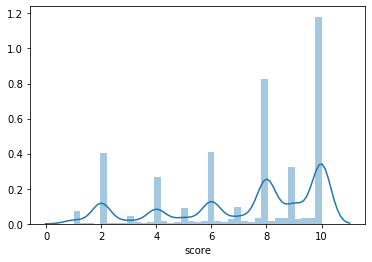

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.distplot(ytr)

plt.show()

############# RandomForestRegressor подготовка #############

In [17]:
ytr[:10]

66734      9.0
62376     10.0
78493      2.7
89276      1.0
73820     10.0
48015     10.0
41700      9.0
134363    10.0
109962     8.0
96023      9.2
Name: score, dtype: float64

In [18]:
from sklearn import utils
ytr1 = ytr.astype('int')
yval1 = yval.astype('int')
utils.multiclass.type_of_target(ytr1)

'multiclass'

In [19]:
ytr1[:10]

66734      9
62376     10
78493      2
89276      1
73820     10
48015     10
41700      9
134363    10
109962     8
96023      9
Name: score, dtype: int32

############# Нейронная сеть #############

In [20]:
# подключим библиотеки keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [21]:
# Опишем нашу сеть.
def baseline_model():
    model_neuraln = Sequential()
    model_neuraln.add(Dense(128, input_dim=Xtr.shape[1], kernel_initializer='normal', activation='relu'))
    model_neuraln.add(Dropout(0.2))
    model_neuraln.add(Dense(64, activation='relu'))
    model_neuraln.add(Dropout(0.5))
    model_neuraln.add(Dense(1, kernel_initializer='normal'))

    model_neuraln.compile(loss='mean_squared_error', optimizer='adam')
    return model_neuraln

In [33]:
estimator = KerasRegressor(build_fn=baseline_model,epochs=20, nb_epoch=20, batch_size=64,validation_data=(Xval, yval), verbose=2)
estimator.fit(Xtr, ytr)

Train on 32892 samples, validate on 16201 samples
Epoch 1/20
 - 1s - loss: 10.4445 - val_loss: 5.7270
Epoch 2/20
 - 1s - loss: 6.9157 - val_loss: 5.4346
Epoch 3/20
 - 1s - loss: 6.6529 - val_loss: 5.3273
Epoch 4/20
 - 1s - loss: 6.4926 - val_loss: 5.4877
Epoch 5/20
 - 1s - loss: 6.3263 - val_loss: 5.1683
Epoch 6/20
 - 1s - loss: 6.2039 - val_loss: 5.1366
Epoch 7/20
 - 1s - loss: 6.1629 - val_loss: 5.3279
Epoch 8/20
 - 1s - loss: 5.9912 - val_loss: 5.2154
Epoch 9/20
 - 1s - loss: 5.9292 - val_loss: 5.1529
Epoch 10/20
 - 1s - loss: 5.7714 - val_loss: 5.1189
Epoch 11/20
 - 1s - loss: 5.6299 - val_loss: 5.0030
Epoch 12/20
 - 1s - loss: 5.5563 - val_loss: 4.9928
Epoch 13/20
 - 1s - loss: 5.4249 - val_loss: 5.2149
Epoch 14/20
 - 1s - loss: 5.3462 - val_loss: 4.9596
Epoch 15/20
 - 1s - loss: 5.2585 - val_loss: 4.9593
Epoch 16/20
 - 1s - loss: 5.1625 - val_loss: 5.0247
Epoch 17/20
 - 1s - loss: 5.0725 - val_loss: 4.9316
Epoch 18/20
 - 1s - loss: 5.0002 - val_loss: 4.9219
Epoch 19/20
 - 1s - lo

In [34]:
y_pred_v = estimator.predict(Xval)

In [37]:
from sklearn.metrics import accuracy_score

y_pred_v1 = y_pred_v.astype('int')

accuracy_score(yval1, y_pred_v1)

0.1351768409357447

In [26]:
df = pd.DataFrame(list(zip(y_pred_v, yval)),
                                 columns = ['y_pred_v', 'yval'])
df.head(30)

,y_pred_v,yval
0,7.954544,8.0
1,8.501387,5.8
2,7.555978,6.0
3,7.690017,6.0
4,8.738216,9.0
5,6.170913,4.0
6,7.153655,10.0
7,7.009925,8.0
8,8.641272,10.0
9,7.239349,7.0


In [40]:
estimator.score(Xval, yval)

-4.980998651031123